In [11]:
import pandas as pd
import numpy as np
import torchviz
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import joblib
from sklearn.preprocessing import StandardScaler
import time
def get_col(df,name):
    return df.columns[df.columns.str.contains(name)].tolist()

# Load data

In [12]:
tag = pd.read_csv('./data/tag盤點表_cleaned.csv',index_col=0)
print(tag.shape)
tag

(95, 10)


,item,TAG,chinese,character,unit,category,period,min,max,推測顯著性(依製程經驗)
0,1.0,MLPAP_TJC-0627.PV,OX預熱器出口溫度,溫度,℃,可控制因子,1分鐘2筆,140,160,***
1,2.0,MLPAP_TRC-0610.PV,空氣預熱器出口溫度,溫度,℃,可控制因子,1分鐘2筆,160,200,***
2,3.0,MLPAP_FR-0632.PV,汽機風量,流量,KNM3/HR,可控制因子,1分鐘2筆,30,90,****
3,4.0,MLPAP_FQ-0619.PV,OX入料量,流量,kg/HR,可控制因子,1分鐘2筆,2000,8000,****
4,5.0,MLPAP_TJC-0757A.PV,反應槽鹽浴溫度,溫度,℃,可控制因子,1分鐘2筆,345,365,****
...,...,...,...,...,...,...,...,...,...,...
90,91.0,MLPAP_TRC-0747.PV,E220出口溫度,溫度,℃,可控制因子,1分鐘2筆,100,200,***
91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,NaN,第二模型使用,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,92.0,MLPAP_V125-PHD,粗PA儲槽PHD,組成,%,不可控制因子,1天1筆,0,0.1,***


In [13]:
df = pd.read_csv('./data/train_cleaned.csv',index_col=0,parse_dates=True)
print(df.shape)
df.head()

(193824, 93)


,MLPAP_TJ-0706B02,MLPAP_TJ-0706B03,MLPAP_TJ-0706B04,MLPAP_TJ-0706B05,MLPAP_TJ-0706B06,MLPAP_TJ-0706B07,MLPAP_TJ-0706B08,MLPAP_TJ-0706B09,MLPAP_TJ-0706B10,MLPAP_TJ-0706B11,...,MLPAP_FQI-0997.PV,DATA OF USE,MLPAP_FR-0755PV(轉換後),MLPAP_FR-0791.PV,MLPAP_FI-V211.PV(轉換後),MLPAP_PI-0658.PV,MLPAP_TJC-0757.PV,MLPAP_V125-PHD,MLPAP_PI-0771.PV,MLPAP_TRC-0747.PV
2016-05-09 00:00:00,400.0,401.95712,400.75186,402.25080,401.14877,401.0,400.05008,403.0,402.0,401.0,...,0.0,0.000005,4.045683,6.484770,NaN,-1.000000,1.635186,0.051,-1.382719,133.1
2016-05-09 00:10:00,400.0,401.94272,400.94990,402.24915,401.00000,401.0,400.24980,403.0,402.0,401.0,...,0.0,0.000010,4.152250,6.449888,NaN,-1.000000,1.625011,0.051,-1.382729,133.1
2016-05-09 00:20:00,400.0,401.90015,400.89978,402.10126,401.00000,401.0,400.10016,403.0,402.0,401.0,...,0.0,0.000014,4.202449,6.440503,NaN,-0.898558,1.649780,0.051,-1.400000,133.1
2016-05-09 00:30:00,400.0,401.94992,400.90020,402.30032,401.00000,401.0,400.14468,403.0,402.0,401.0,...,0.0,0.000019,4.146723,6.463649,NaN,-0.509010,1.635187,0.051,-1.400000,133.2
2016-05-09 00:40:00,400.0,402.00000,400.85004,402.17606,401.00000,401.0,400.40500,403.0,402.0,401.0,...,0.0,0.000024,4.011298,6.414799,NaN,-0.992771,1.654259,0.051,-1.300000,133.1


In [14]:
set(df.columns)^set(tag.TAG)

{nan, '第二模型使用'}

# spec clip or to np.nan

In [15]:
for i in tqdm(df.columns):
    if i == 'DATA OF USE':
        continue
    print(i)
    lb = float(tag[tag['TAG']==i]['min'].values[0])
    ub = float(tag[tag['TAG']==i]['max'].values[0])
    out = (df[i]<lb)|(df[i]>ub)
    
    '''
    超過spec的要 做clip 或著轉成 np.nan
    '''
    #df[i] = np.clip(df[i].values,lb,ub)
    df.loc[out,i] = np.nan

df.head()

MLPAP_TJ-0706B02
MLPAP_TJ-0706B03
MLPAP_TJ-0706B04
MLPAP_TJ-0706B05
MLPAP_TJ-0706B06
MLPAP_TJ-0706B07
MLPAP_TJ-0706B08
MLPAP_TJ-0706B09
MLPAP_TJ-0706B10
MLPAP_TJ-0706B11
MLPAP_TJ-0706B12
MLPAP_TJ-0706B13
MLPAP_TJ-0706B14
MLPAP_TJ-0706B15
MLPAP_TJ-0706B16
MLPAP_TJ-0706B17
MLPAP_TJ-0706B18
MLPAP_TJ-0706B19
MLPAP_TJ-0706B20
MLPAP_TJ-0706B21
MLPAP_TJ-0706B22
MLPAP_TJ-0706B23
MLPAP_TJ-0706B24
MLPAP_TJ-0716A02
MLPAP_TJ-0716A03
MLPAP_TJ-0716A04
MLPAP_TJ-0716A05
MLPAP_TJ-0716A06
MLPAP_TJ-0716A07
MLPAP_TJ-0716A08
MLPAP_TJ-0716A09
MLPAP_TJ-0716A10
MLPAP_TJ-0716A11
MLPAP_TJ-0716A12
MLPAP_TJ-0716A13
MLPAP_TJ-0716A14
MLPAP_TJ-0716A15
MLPAP_TJ-0716A16
MLPAP_TJ-0716A17
MLPAP_TJ-0716A18
MLPAP_TJ-0716A19
MLPAP_TJ-0716A20
MLPAP_TJ-0716A21
MLPAP_TJ-0716A22
MLPAP_TJ-0716A23
MLPAP_TJR-0715A1.PV
MLPAP_TJR-0715A2.PV
MLPAP_TJR-0715B1.PV
MLPAP_TJR-0715B2.PV
MLPAP_TJR-0720A1.PV
MLPAP_TJR-0720A2.PV
MLPAP_TJR-0720B1.PV
MLPAP_TJR-0720B2.PV
MLPAP_TJR-0762A1.PV
MLPAP_TJR-0762A2.PV
MLPAP_TJR-0762B1.PV
MLPAP_TJR-0762B

,MLPAP_TJ-0706B02,MLPAP_TJ-0706B03,MLPAP_TJ-0706B04,MLPAP_TJ-0706B05,MLPAP_TJ-0706B06,MLPAP_TJ-0706B07,MLPAP_TJ-0706B08,MLPAP_TJ-0706B09,MLPAP_TJ-0706B10,MLPAP_TJ-0706B11,...,MLPAP_FQI-0997.PV,DATA OF USE,MLPAP_FR-0755PV(轉換後),MLPAP_FR-0791.PV,MLPAP_FI-V211.PV(轉換後),MLPAP_PI-0658.PV,MLPAP_TJC-0757.PV,MLPAP_V125-PHD,MLPAP_PI-0771.PV,MLPAP_TRC-0747.PV
2016-05-09 00:00:00,400.0,401.95712,400.75186,402.25080,401.14877,401.0,400.05008,403.0,402.0,401.0,...,NaN,0.000005,4.045683,NaN,NaN,NaN,1.635186,0.051,NaN,133.1
2016-05-09 00:10:00,400.0,401.94272,400.94990,402.24915,401.00000,401.0,400.24980,403.0,402.0,401.0,...,NaN,0.000010,4.152250,NaN,NaN,NaN,1.625011,0.051,NaN,133.1
2016-05-09 00:20:00,400.0,401.90015,400.89978,402.10126,401.00000,401.0,400.10016,403.0,402.0,401.0,...,NaN,0.000014,4.202449,NaN,NaN,NaN,1.649780,0.051,NaN,133.1
2016-05-09 00:30:00,400.0,401.94992,400.90020,402.30032,401.00000,401.0,400.14468,403.0,402.0,401.0,...,NaN,0.000019,4.146723,NaN,NaN,NaN,1.635187,0.051,NaN,133.2
2016-05-09 00:40:00,400.0,402.00000,400.85004,402.17606,401.00000,401.0,400.40500,403.0,402.0,401.0,...,NaN,0.000024,4.011298,NaN,NaN,NaN,1.654259,0.051,NaN,133.1


# define columns

In [16]:
control_factor = tag[tag['category']=='可控制因子']['TAG'].values.tolist()
INPUT = get_col(df,'0619')
OUTPUT = get_col(df,'0997')
control_factor = list(set(control_factor) - set(INPUT) - set(OUTPUT))
control_factor = sorted(control_factor)
control_factor

['MLPAP_FR-0632.PV',
 'MLPAP_LIC-0738.PV',
 'MLPAP_LRC-0729.PV',
 'MLPAP_PIC-0741.PV',
 'MLPAP_PIC-0761.PV',
 'MLPAP_TJ-0757B.PV',
 'MLPAP_TJC-0627.PV',
 'MLPAP_TJC-0757.PV',
 'MLPAP_TJC-0757A.PV',
 'MLPAP_TJC-1721.PV',
 'MLPAP_TRC-0610.PV',
 'MLPAP_TRC-0747.PV',
 'MLPAP_TRC-0762.PV',
 'MLPAP_TRC-1734.PV']

In [17]:
df = df[INPUT+control_factor+OUTPUT]
df.head()

,MLPAP_FQ-0619.PV,MLPAP_FR-0632.PV,MLPAP_LIC-0738.PV,MLPAP_LRC-0729.PV,MLPAP_PIC-0741.PV,MLPAP_PIC-0761.PV,MLPAP_TJ-0757B.PV,MLPAP_TJC-0627.PV,MLPAP_TJC-0757.PV,MLPAP_TJC-0757A.PV,MLPAP_TJC-1721.PV,MLPAP_TRC-0610.PV,MLPAP_TRC-0747.PV,MLPAP_TRC-0762.PV,MLPAP_TRC-1734.PV,MLPAP_FQI-0997.PV
2016-05-09 00:00:00,NaN,NaN,NaN,NaN,NaN,46.90000,NaN,NaN,1.635186,NaN,63.684563,NaN,133.1,NaN,182.19559,NaN
2016-05-09 00:10:00,NaN,NaN,NaN,NaN,NaN,46.90000,NaN,NaN,1.625011,NaN,61.767097,NaN,133.1,NaN,182.14304,NaN
2016-05-09 00:20:00,NaN,NaN,NaN,NaN,NaN,46.93004,NaN,NaN,1.649780,NaN,62.294110,NaN,133.1,NaN,178.69830,NaN
2016-05-09 00:30:00,NaN,NaN,NaN,NaN,NaN,46.90000,NaN,NaN,1.635187,NaN,61.901653,NaN,133.2,NaN,179.14742,NaN
2016-05-09 00:40:00,NaN,NaN,NaN,NaN,NaN,46.90000,NaN,NaN,1.654259,NaN,61.953600,NaN,133.1,NaN,183.34135,NaN


# miss value

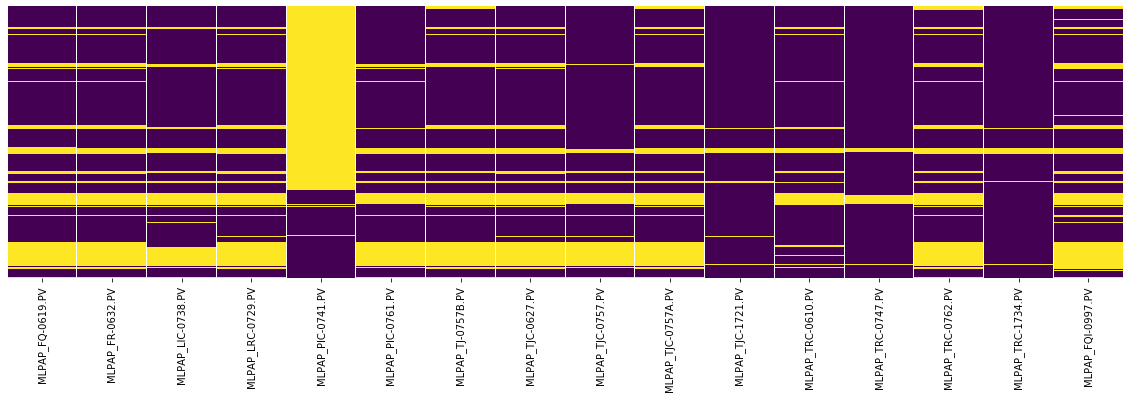

In [18]:
fig = plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# dropna(columns wise)

In [19]:
df = df.dropna(axis=1,thresh=len(df)*0.6)

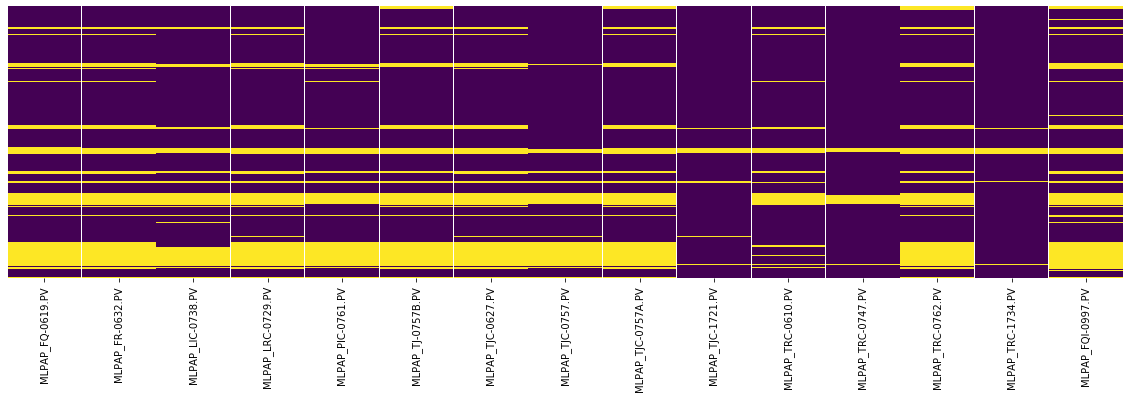

In [20]:
fig = plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [21]:
control_factor = list(set(df.columns)&set(control_factor))
control_factor = sorted(control_factor)
control_factor

['MLPAP_FR-0632.PV',
 'MLPAP_LIC-0738.PV',
 'MLPAP_LRC-0729.PV',
 'MLPAP_PIC-0761.PV',
 'MLPAP_TJ-0757B.PV',
 'MLPAP_TJC-0627.PV',
 'MLPAP_TJC-0757.PV',
 'MLPAP_TJC-0757A.PV',
 'MLPAP_TJC-1721.PV',
 'MLPAP_TRC-0610.PV',
 'MLPAP_TRC-0747.PV',
 'MLPAP_TRC-0762.PV',
 'MLPAP_TRC-1734.PV']

# stack time_step

In [22]:
x_col = INPUT+control_factor
y_col = OUTPUT

def train_windows(df, ref_day):
    X_train, Y_train, idx_lst = [], [], []
    for i in tqdm(range(len(df)-ref_day)):
        # 起始日 結束日
        start,end = i,i+ref_day
        # 確定該筆instance涵蓋的時間範圍內是否皆不含缺失值
        c = df.iloc[start:end+1].isnull().sum().sum()
        # 如果正常(不含缺失值)才製作成X,y pair
        if c == 0:
            X_train.append(df.iloc[start:end+1][x_col].values)
            Y_train.append(df.iloc[end][y_col].values[0])
            idx_lst.append(df.iloc[[end]].index[0])
        # 如果不正常就跳過
        else:
            pass
    # 重整資料 將二維X做flat 將y變Series
    X_train = np.array(X_train)
    flat_size = X_train.shape[1]*X_train.shape[2]
    X_train = X_train.reshape(-1,flat_size)
    Y_train = pd.Series(Y_train,index=idx_lst,name='Y')
    return X_train, Y_train, idx_lst

# make X,y pair need long time

In [23]:
s = time.time()
X,Y,idx_lst = train_windows(df,38)
Y = Y.values.reshape(-1,1)
print(time.time()-s)
print(X.shape)
print(Y.shape)


910.1672835350037
(134869, 546)
(134869, 1)


# save X,y

In [24]:
dataset = {}
dataset['X'] = X
dataset['Y'] = Y
dataset['idx'] = idx_lst
joblib.dump(dataset,'./data/dataset(preprocessing)')
print('save done')

save done


# split train test

In [25]:
sp1 = int(len(X)*0.7)
sp2 = int(len(X)*0.85)
X_train,X_valid,X_test = X[:sp1],X[sp1:sp2],X[sp2:]
Y_train,Y_valid,Y_test = Y[:sp1],Y[sp1:sp2],Y[sp2:]
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(94408, 546)
(94408, 1)
(20230, 546)
(20230, 1)
(20231, 546)
(20231, 1)


# MinMaxScaler

In [26]:
from sklearn.preprocessing import MinMaxScaler
mm_x = MinMaxScaler().fit(X)
mm_y = MinMaxScaler().fit(Y)

In [27]:
joblib.dump(mm_x,'./model/mm_x.pkl')
joblib.dump(mm_y,'./model/mm_y.pkl')
print('save done!')

save done!


# scale 

In [28]:
X_train = mm_x.transform(X_train)
X_valid = mm_x.transform(X_valid)
X_test = mm_x.transform(X_test)

Y_train = mm_y.transform(Y_train)
Y_valid = mm_y.transform(Y_valid)
Y_test = mm_y.transform(Y_test)

# torch tensor

In [29]:
import torch

X_train = torch.tensor(X_train).cuda()
X_test = torch.tensor(X_test).cuda()

X_valid = torch.tensor(X_valid).cuda()
Y_valid = torch.tensor(Y_valid).cuda()

Y_train = torch.tensor(Y_train).cuda()
Y_test = torch.tensor(Y_test).cuda()

# data_iter

In [30]:
train = torch.utils.data.TensorDataset(X_train, Y_train)
valid = torch.utils.data.TensorDataset(X_valid, Y_valid)
train_iter = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)
valid_iter = torch.utils.data.DataLoader(valid, batch_size=256, shuffle=True)

# Construct the neural network

In [31]:
class Net(nn.Module):
    def __init__(self,input_shape,output_shape):
        super(Net,self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_shape,64),#高維度輸入特徵降維至64的內部特徵表示
            nn.Dropout(0.2),#對抗過擬和
            nn.Linear(64,output_shape),#輸出0997的值
            nn.Sigmoid(),# 將range限縮在[0,1]
        )

    def forward(self, x):
        return self.fc(x)

In [32]:
def init_weights(m):
    if hasattr(m,'weight'):
        torch.nn.init.xavier_uniform(m.weight)
    if hasattr(m,'bias'):
        m.bias.data.fill_(0)

In [33]:
net = Net(X_train.shape[1],Y_train.shape[1]).cuda().double()
net.apply(init_weights)

C:\Users\skywalker0803r\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Net(
  (fc): Sequential(
    (0): Linear(in_features=546, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

# tensorboard

In [34]:
#with SummaryWriter(comment='Net')as w:
#    w.add_graph(net, (X_test,))

# torchviz

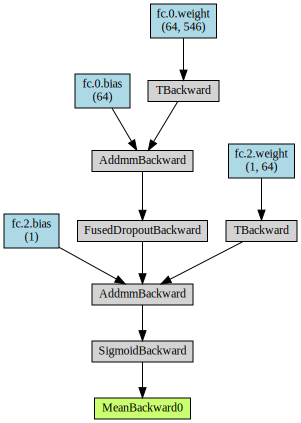

In [35]:
torchviz.make_dot(net(X_test).mean(),params=dict(net.named_parameters()))

# loss_function and optimizer

In [36]:
optimizer = torch.optim.Adam(net.parameters(),lr=1e-4)
loss_function = nn.MSELoss()

# Training and evaluation

In [37]:
def train(net,train_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    for epoch in range(num_epochs): 
        
        # train model
        net.train()
        train_loss,i = 0,0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
            i += 1
        
        # eval model
        with torch.no_grad():
            net.eval()
            val_loss,j = 0,0
            for x, y in valid_iter:
                loss = loss_function(net(x),y)
                val_loss += loss.item()
                j += 1
        
        # caculate avg loss
        train_avg_loss = train_loss/i
        val_avg_loss = val_loss/j
        
        # save the best model
        if val_avg_loss <= best_loss:
            best_loss = val_avg_loss
            joblib.dump(net,'./model/net.pkl')
            print('model saved')
        
        # record history and print loss of the epoch
        train_history.append(train_avg_loss)
        valid_history.append(val_avg_loss)
        print("epochs {} train_avg_loss {:.4f} valid_avg_loss {:.4f}".format(epoch,train_avg_loss,val_avg_loss))
        
    # plot result
    print('best val_avg_loss is ',best_loss)
    fig = plt.figure(figsize=(20,5))
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.legend()
    plt.title('loss')
    plt.show()
    print('model save at ./model/net.pkl')

model saved
epochs 0 train_avg_loss 0.0066 valid_avg_loss 0.0022
model saved
epochs 1 train_avg_loss 0.0017 valid_avg_loss 0.0018
epochs 2 train_avg_loss 0.0014 valid_avg_loss 0.0020
epochs 3 train_avg_loss 0.0013 valid_avg_loss 0.0021
epochs 4 train_avg_loss 0.0013 valid_avg_loss 0.0020
epochs 5 train_avg_loss 0.0013 valid_avg_loss 0.0020
epochs 6 train_avg_loss 0.0012 valid_avg_loss 0.0020
epochs 7 train_avg_loss 0.0012 valid_avg_loss 0.0018
model saved
epochs 8 train_avg_loss 0.0012 valid_avg_loss 0.0017
model saved
epochs 9 train_avg_loss 0.0012 valid_avg_loss 0.0017
best val_avg_loss is  0.0016777582461726791


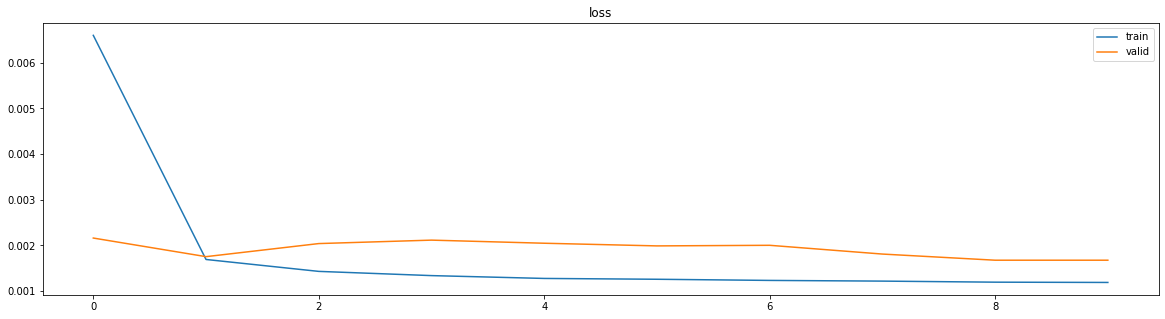

model save at ./model/net.pkl
82.46890497207642


In [38]:
s = time.time()
train(net,train_iter,loss_function,optimizer,num_epochs=10)
print(time.time()-s)

# load best net

In [39]:
net = joblib.load('./model/net.pkl')
net.eval()

Net(
  (fc): Sequential(
    (0): Linear(in_features=546, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

# metrics

In [40]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from math import sqrt

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))


feed = X.reshape(-1,39,14).mean(axis=1)
feed = pd.DataFrame(feed,columns=x_col,index=idx_lst)
feed = feed['MLPAP_FQ-0619.PV']

def show_result(X,Y,index):
    t = pd.DataFrame(index=index)
    t['0619'] = feed[index]
    t['0997_real'] = mm_y.inverse_transform(Y.detach().cpu().numpy().reshape(-1,1)).ravel()
    t['0997_pred'] = mm_y.inverse_transform(net(X).detach().cpu().numpy().reshape(-1,1)).ravel()
    t['單耗_real'] = t['0619']/t['0997_real']
    t['單耗_pred'] = t['0619']/t['0997_pred']
    t['0997_R2'] = r2_score(t['0997_real'],t['0997_pred'])
    t['0997_MAPE'] = mape(t['0997_real'],t['0997_pred'])
    t['單耗RMSE'] = sqrt(mean_squared_error(t['單耗_real'],t['單耗_pred']))
    return t

# make prediction(train)

In [41]:
t1 = show_result(X_train,Y_train,idx_lst[:sp1])
t1.head()

,0619,0997_real,0997_pred,單耗_real,單耗_pred,0997_R2,0997_MAPE,單耗RMSE
2016-06-01 02:40:00,5694.148613,6467.7600,6371.520602,0.880390,0.893688,0.854969,0.012118,0.018867
2016-06-01 02:50:00,5694.210400,6450.8740,6377.741089,0.882704,0.892826,0.854969,0.012118,0.018867
2016-06-01 03:00:00,5693.874564,6443.6900,6357.573929,0.883636,0.895605,0.854969,0.012118,0.018867
2016-06-01 03:10:00,5694.258010,6430.3833,6379.842084,0.885524,0.892539,0.854969,0.012118,0.018867
2016-06-01 03:20:00,5694.593251,6446.3940,6373.018506,0.883377,0.893547,0.854969,0.012118,0.018867


# make prediction(valid)

In [42]:
t2 = show_result(X_valid,Y_valid,idx_lst[sp1:sp2])
t2.head()

,0619,0997_real,0997_pred,單耗_real,單耗_pred,0997_R2,0997_MAPE,單耗RMSE
2018-07-30 13:50:00,6475.965938,7170.4375,7209.593740,0.903148,0.898243,0.89625,0.018413,0.025182
2018-07-30 14:00:00,6476.258646,7177.4155,7199.132081,0.902311,0.899589,0.89625,0.018413,0.025182
2018-07-30 14:10:00,6476.449967,7186.3833,7232.985099,0.901211,0.895405,0.89625,0.018413,0.025182
2018-07-30 14:20:00,6476.812182,7188.4920,7224.596829,0.900997,0.896495,0.89625,0.018413,0.025182
2018-07-30 14:30:00,6477.298300,7160.7270,7207.175135,0.904559,0.898729,0.89625,0.018413,0.025182


# make prediction(test)

In [43]:
t3 = show_result(X_test,Y_test,idx_lst[sp2:])
t3.head()

,0619,0997_real,0997_pred,單耗_real,單耗_pred,0997_R2,0997_MAPE,單耗RMSE
2019-03-31 04:50:00,6684.874813,7311.6600,7677.510479,0.914276,0.870709,0.651454,0.035319,0.038511
2019-03-31 05:00:00,6684.801633,7314.2090,7712.111664,0.913947,0.866793,0.651454,0.035319,0.038511
2019-03-31 05:10:00,6684.704226,7291.8360,7670.984628,0.916738,0.871427,0.651454,0.035319,0.038511
2019-03-31 05:20:00,6684.683628,7272.4634,7630.233022,0.919177,0.876079,0.651454,0.035319,0.038511
2019-03-31 05:30:00,6684.581285,7290.4190,7694.512466,0.916899,0.868747,0.651454,0.035319,0.038511


In [44]:
pred_0997_all = t1.append(t2).append(t3)['0997_pred']
pred_0997_all.head()

2016-06-01 02:40:00    6371.520602
2016-06-01 02:50:00    6377.741089
2016-06-01 03:00:00    6357.573929
2016-06-01 03:10:00    6379.842084
2016-06-01 03:20:00    6373.018506
Name: 0997_pred, dtype: float64

In [46]:
pred_0997_all.to_csv('./data/pred_0997_all.csv')
print('save done')

C:\Users\skywalker0803r\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


save done
